# Tutorial

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scikit-learn-toy-data-sets" data-toc-modified-id="Scikit-learn-toy-data-sets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scikit-learn toy data sets</a></span></li><li><span><a href="#Getting-started" data-toc-modified-id="Getting-started-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting started</a></span></li><li><span><a href="#Parameter-scan" data-toc-modified-id="Parameter-scan-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameter scan</a></span></li><li><span><a href="#Hierarchical-clustering" data-toc-modified-id="Hierarchical-clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hierarchical clustering</a></span></li><li><span><a href="#Space-A" data-toc-modified-id="Space-A-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Space A</a></span><ul class="toc-item"><li><span><a href="#Clustering" data-toc-modified-id="Clustering-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Coreset-MSM-estimation" data-toc-modified-id="Coreset-MSM-estimation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Coreset MSM estimation</a></span><ul class="toc-item"><li><span><a href="#(MSM-on-train-data-dt-=-10-ns)" data-toc-modified-id="(MSM-on-train-data-dt-=-10-ns)-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>(MSM on train data <em>dt</em> = 10 ns)</a></span></li></ul></li></ul></li><li><span><a href="#Space-B" data-toc-modified-id="Space-B-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Space B</a></span><ul class="toc-item"><li><span><a href="#Clustering" data-toc-modified-id="Clustering-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Coreset-MSM-estimation" data-toc-modified-id="Coreset-MSM-estimation-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Coreset MSM estimation</a></span><ul class="toc-item"><li><span><a href="#(MSM-on-test-data-dt-=-0.1-ns)" data-toc-modified-id="(MSM-on-test-data-dt-=-0.1-ns)-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>(MSM on test data <em>dt</em> = 0.1 ns)</a></span></li></ul></li></ul></li></ul></div>

# Pre-requirements

In [1]:
# Primary imports
import importlib  # Only need for module editing
from IPython.display import Image
import json
from os.path import expandvars
import pandas as pd
from pathlib import Path
import sys
import time
import warnings
warnings.simplefilter("always")  # Surpress warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets  # For sklearn test data set creation
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# CNN clustering module
import core.cnn as cnn
import core.cmsm as cmsm

In [2]:
# Configuration file found?
cnn.settings.cfgfile

In [3]:
cnn.settings.defaults

{'default_cnn_cutoff': '1',
 'default_cnn_offset': '0',
 'default_radius_cutoff': '1',
 'default_member_cutoff': '2',
 'float_precision': 'sp',
 'int_precision': 'sp'}

In [4]:
# Matplotlib configuration
mpl.rc_file(
    f"{expandvars('matplotlibrc')}",
    use_default_template=False
)

In [5]:
# Pandas DataFrame print options
pd.set_option('display.max_rows', 1000)

In [6]:
# Version information
print(sys.version)

3.8.1 (default, Jan 23 2020, 07:59:15) 
[GCC 8.3.0]


## Scikit-learn toy data sets

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [7]:
# Data set generation parameters
np.random.seed(0)
n_samples = 2000

In [8]:
# Toy data set generation
# circles
noisy_circles, _ = datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05
    )

# moons
noisy_moons, _ = datasets.make_moons(
    n_samples=n_samples,
    noise=.05
    )

# blobs
blobs, _ = datasets.make_blobs(
    n_samples=n_samples,
    random_state=8
    )

# None
no_structure = np.random.rand(
    n_samples, 2
    )

# aniso
random_state = 170
X, y = datasets.make_blobs(
    n_samples=n_samples,
    random_state=random_state
    )

transformation = [[0.6, -0.6], [-0.4, 0.8]]
aniso = np.dot(X, transformation)

# varied
varied, _ = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [9]:
# Define cluster parameters
dsets = [
    ('circles', noisy_circles, {
        'radius_cutoff': 0.5,
        'cnn_cutoff': 20,
        'member_cutoff': 100,
        'max_clusters': None
        }),
    ('moons', noisy_moons, {
        'radius_cutoff': 0.5,
        'cnn_cutoff': 20,
        'member_cutoff': 2,
        'max_clusters': None
        }),
    ('varied', varied, {
        'radius_cutoff': 0.28,
        'cnn_cutoff': 20,
        'member_cutoff': 20,
        'max_clusters': None
        }),
    ('aniso', aniso, {
        'radius_cutoff': 0.29,
        'cnn_cutoff': 30,
        'member_cutoff': 5,
        'max_clusters': None
         }),
    ('blobs', blobs, {
        'radius_cutoff': 0.4,
        'cnn_cutoff': 20,
        'member_cutoff': 2,
        'max_clusters': None
        }),
    ('None', no_structure, {
        'radius_cutoff': 0.5,
        'cnn_cutoff': 20,
        'member_cutoff': 1,
        'max_clusters': None
        }),
    ]

In [10]:
# Axis property defaults for the following plots
ax_props = {
    "xlabel": None,
    "ylabel": None,
    "xlim": (-2.5, 2.5),
    "ylim": (-2.5, 2.5),
    "xticks": (),
    "yticks": (),
    "aspect": "equal"
}

# Line plot property defaults
line_props = {
    "linewidth": 0,
    "marker": '.',
}

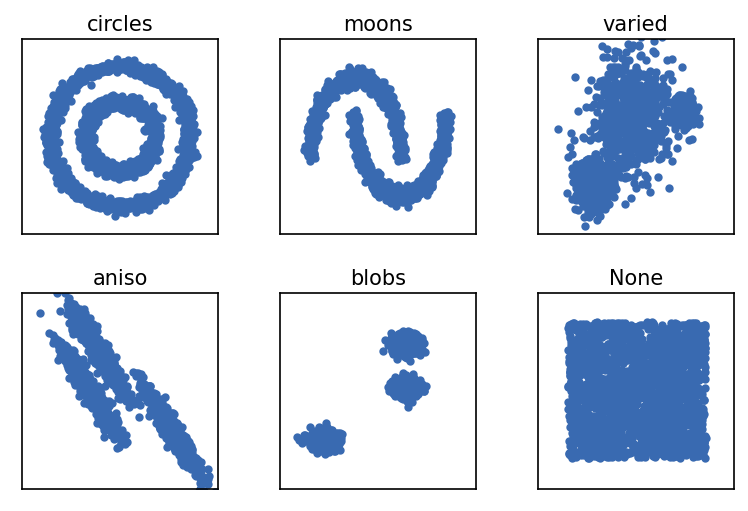

In [11]:
# Plot the original data sets
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, *_) in enumerate(dsets):
    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)
    # Plot
    Ax[count].plot(data[:, 0], data[:, 1], **line_props)
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )


Execution time for call of fit: 0 hours, 0 minutes, 0.1848 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
2000      0.500     20        100       None      2         0.500     0.000     
--------------------------------------------------------------------------------

Execution time for call of fit: 0 hours, 0 minutes, 0.2603 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
2000      0.500     20        2         None      2         0.500     0.000     
--------------------------------------------------------------------------------

Execution time for call of fit: 0 hours, 0 minutes, 0.3917 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest

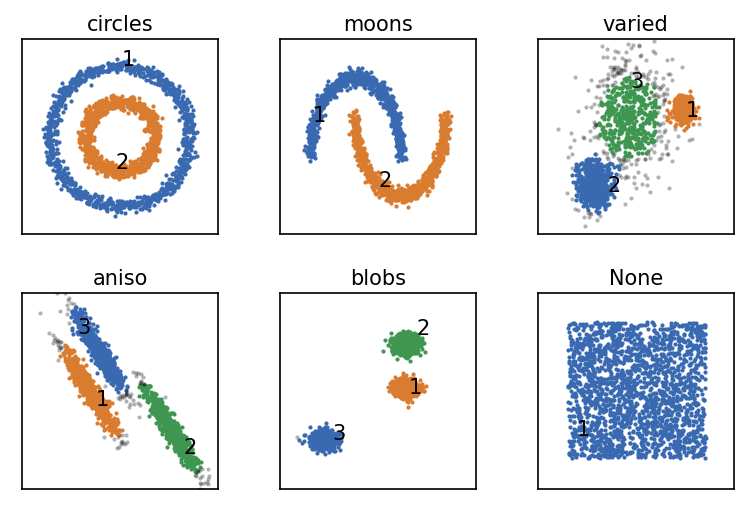

In [12]:
# Cluster the sets and plot the result
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()

for count, (name, data, params) in enumerate(dsets):
    # Fit all datasets to the same value range
    data = StandardScaler().fit_transform(data)
    
    clustering = cnn.CNN(points=data)
    clustering.calc_dist()  # Pre-calculate distances from points
    clustering.fit(**params)
    print()
    
    # Plot
    clustering.evaluate(ax=Ax[count], annotate_pos="random")
    Ax[count].set(**ax_props)
    Ax[count].set_title(f'{name}', fontsize=10, pad=4)
    
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

# Dissimilar blobs showcase

## Getting started

In [13]:
importlib.reload(cnn) 

<module 'core.cnn' from '/home/janjoswig/CNN/core/cnn.py'>

In [14]:
# Generate blobs with quite different point densities
dblobs, _ = datasets.make_blobs(
    n_samples=int(1e5),
    cluster_std=[3.5, 0.32, 1.8],
    random_state=1
    )

dblobs = StandardScaler().fit_transform(dblobs)

In [15]:
# Initialise clustering
cobj = cnn.CNN(points=dblobs)

In [16]:
# Get basic information about the cnn.CNN instance via cobj.__str__()
print(cobj)


core.cnn.CNN cluster object
-------------------------------------------------------------------------------
alias :                         root
hierachy level :                0

data point shape :              Parts      - 1
                                Points     - 100000
                                Dimensions - 2

distance matrix calculated :    0
neighbour list calculated :     0, r=None
clustered :                     True
children :                      False



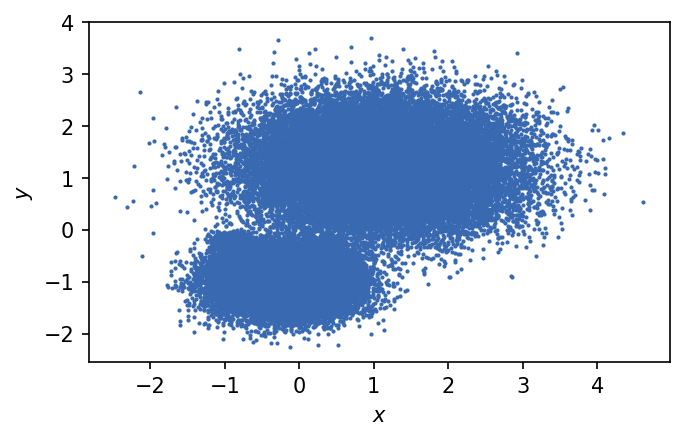

In [17]:
# Plot the original data
_ = cobj.evaluate()

In [18]:
# To make the clustering easier, reduce the number of points
# (start, stop, stride)
robj = cobj.cut(points=(None, None, 100))
# Equivalent to:
#     >>> robj = cnn.CNN(points=cobj.data.points[slice(None, None, 100), :])

In [19]:
print(robj)


core.cnn.CNN cluster object
-------------------------------------------------------------------------------
alias :                         root
hierachy level :                0

data point shape :              Parts      - 1
                                Points     - 1000
                                Dimensions - 2

distance matrix calculated :    0
neighbour list calculated :     0, r=None
clustered :                     True
children :                      False



Text(0.5, 1.0, '1000 points')

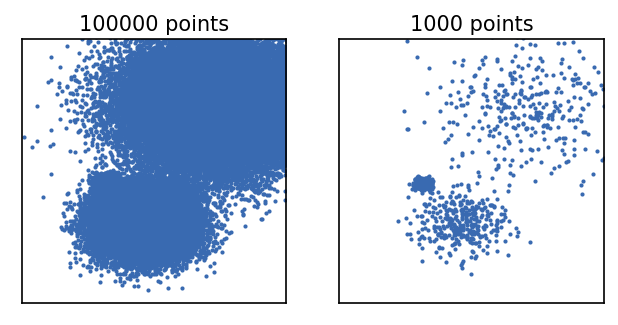

In [20]:
# Plot the reduced data
fig, Ax = plt.subplots(1, 2)
_ = cobj.evaluate(ax=Ax[0], ax_props=ax_props)
_ = robj.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[0].set_title(f"{cobj.data.points.shape[0]} points", fontsize=10, pad=4)
Ax[1].set_title(f"{robj.data.points.shape[0]} points", fontsize=10, pad=4)

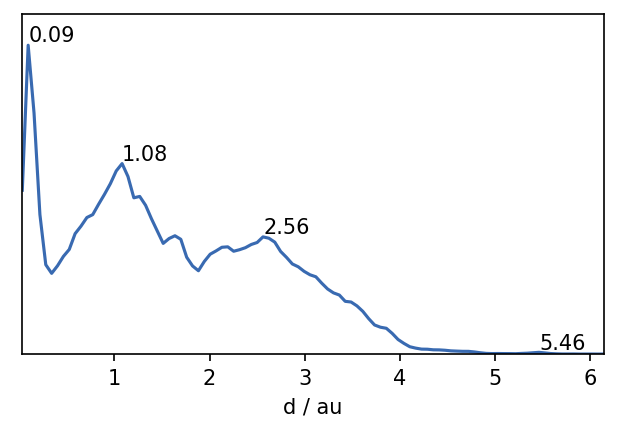

In [21]:
# Looking at the distance distribution between points, can help to find an
# initial value for the radius cutoff
robj.calc_dist()  # Pre-calculate distances
fig, ax, *_ = robj.dist_hist(maxima=True, maxima_props={"order": 5})

## Parameter scan

In [22]:
# A scan of a few parameters shows that it is difficult to extract the
# three clusters at once with one parameter set
for r in [0.1, 0.5, 1, 2,]:  # [0.01, 0.03, 0.06, 0.08, 0.1, 0.12, 0.15, 0.2, 0.3, 0.4, 0.5, 1., 2., 3., 4.]:
    for c in [0, 1, 3, 5]:  # [0, 1, 2, 3, 4, 5, 10, 15, 20]:
        robj.fit(r, c)

Execution time for call of fit: 0 hours, 0 minutes, 0.2167 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
1000      0.100     0         2         None      75        0.334     0.128     
--------------------------------------------------------------------------------
Execution time for call of fit: 0 hours, 0 minutes, 0.0125 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
1000      0.100     1         2         None      32        0.334     0.308     
--------------------------------------------------------------------------------
Execution time for call of fit: 0 hours, 0 minutes, 0.0116 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  

In [23]:
print(*robj.summary, sep="\n")

CNNRecord(points=1000, r=0.1, n=0, m=2, max=None, clusters=Labels(75), largest=0.334, noise=0.128, time=0.2167348861694336)
CNNRecord(points=1000, r=0.1, n=1, m=2, max=None, clusters=Labels(32), largest=0.334, noise=0.308, time=0.012508392333984375)
CNNRecord(points=1000, r=0.1, n=3, m=2, max=None, clusters=Labels(20), largest=0.333, noise=0.45, time=0.011631488800048828)
CNNRecord(points=1000, r=0.1, n=5, m=2, max=None, clusters=Labels(11), largest=0.331, noise=0.538, time=0.013011455535888672)
CNNRecord(points=1000, r=0.5, n=0, m=2, max=None, clusters=Labels(1), largest=0.996, noise=0.004, time=0.08052229881286621)
CNNRecord(points=1000, r=0.5, n=1, m=2, max=None, clusters=Labels(1), largest=0.994, noise=0.006, time=0.02983880043029785)
CNNRecord(points=1000, r=0.5, n=3, m=2, max=None, clusters=Labels(1), largest=0.985, noise=0.015, time=0.03208041191101074)
CNNRecord(points=1000, r=0.5, n=5, m=2, max=None, clusters=Labels(1), largest=0.98, noise=0.02, time=0.030623435974121094)
CNNR

In [24]:
robj.summary.to_DataFrame().sort_values('clusters')

,points,r,n,m,max,clusters,largest,noise,time
4,1000,0.5,0,2,<NA>,1,0.996,0.004,0.080522
5,1000,0.5,1,2,<NA>,1,0.994,0.006,0.029839
6,1000,0.5,3,2,<NA>,1,0.985,0.015,0.032080
7,1000,0.5,5,2,<NA>,1,0.980,0.020,0.030623
8,1000,1.0,0,2,<NA>,1,0.999,0.001,0.168202
9,1000,1.0,1,2,<NA>,1,0.998,0.002,0.046836
10,1000,1.0,3,2,<NA>,1,0.996,0.004,0.048248
11,1000,1.0,5,2,<NA>,1,0.995,0.005,0.048657
12,1000,2.0,0,2,<NA>,1,1.000,0.000,0.195593
13,1000,2.0,1,2,<NA>,1,1.000,0.000,0.076243


In [25]:
# cluster results where we have 2, 3 or 4 clusters
df = robj.summary.to_DataFrame()
df[(df.clusters > 1) & (df.clusters < 5)]

,points,r,n,m,max,clusters,largest,noise,time


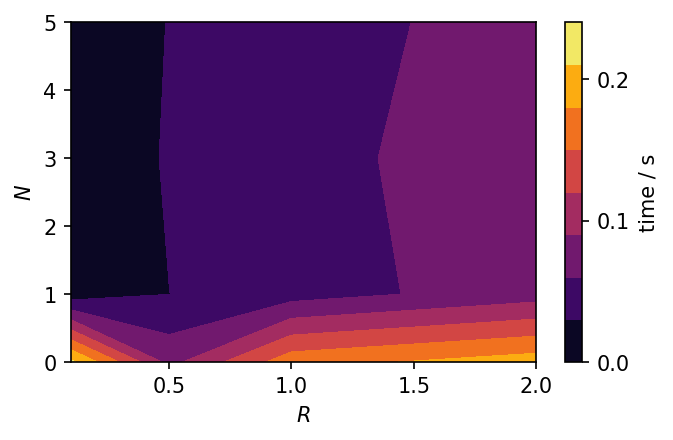

In [26]:
# Summarize the summary table as 2D contour plot
# time
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax)[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.1, 0.2))
colorbar.set_label("time / s")

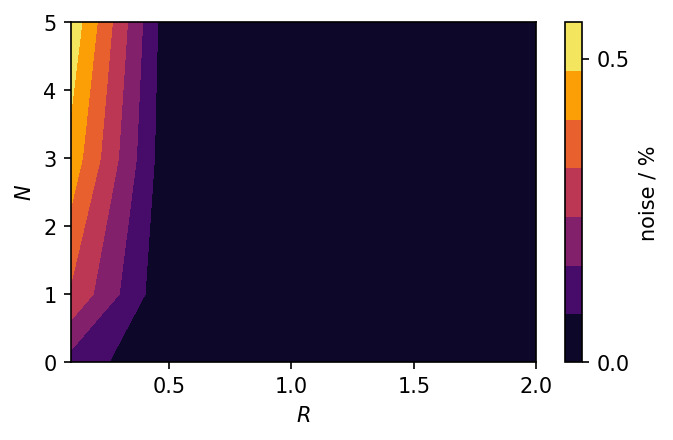

In [27]:
# Summarize the summary table as 2D contour plot
# noise
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax, quant="noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("noise / %")

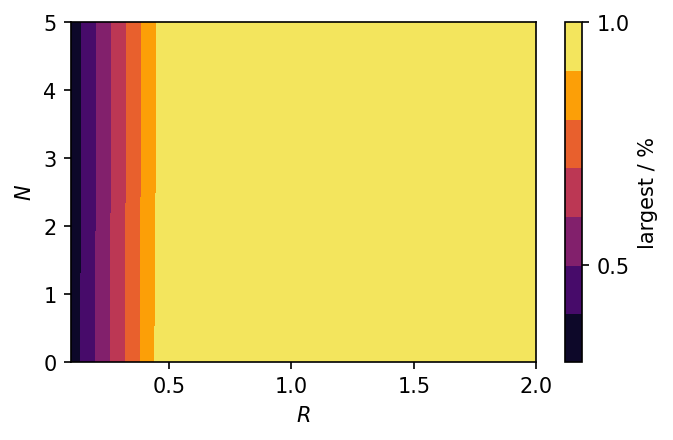

In [28]:
# Summarize the summary table as 2D contour plot
# largest cluster
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax, quant="largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("largest / %")

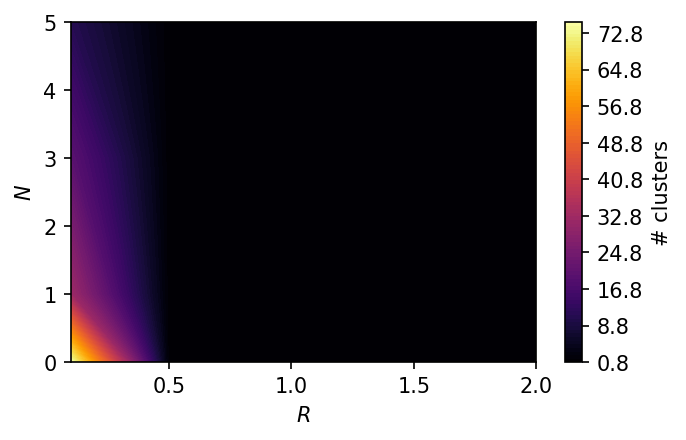

In [29]:
# Summarize the summary table as 2D contour plot
# cluster number
fig, ax = plt.subplots()
contour = robj.summary.summarize(ax=ax, quant="clusters",
                         contour_props={"levels": 100})[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
colorbar.set_label("# clusters")

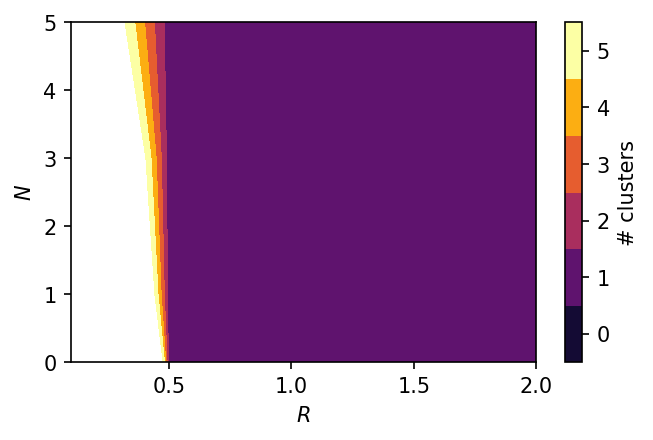

In [30]:
# Summarize the summary table as 2D contour plot
# cluster number with adjusted coloring
fig, ax = plt.subplots()
contour = robj.summary.summarize(
    ax=ax, quant="clusters",
    contour_props={"levels": [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
                   "vmax": 5}
    )[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 1, 2, 3, 4, 5))
colorbar.set_label("# clusters")

## Hierarchical clustering

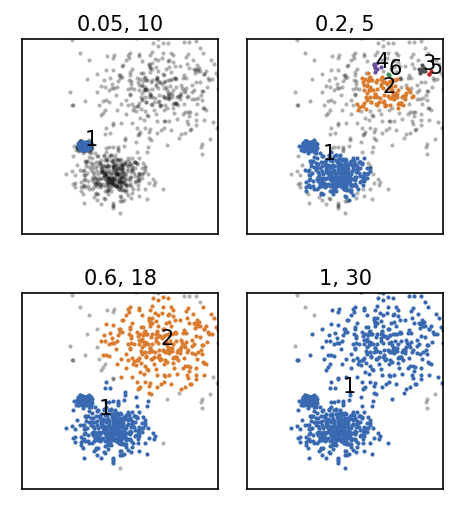

In [31]:
# Cluster attempts in comparison
fig, ax = plt.subplots(2, 2)
Ax = ax.flatten()
for i, pair in enumerate([(0.05, 10), (0.2, 5), (0.6, 18), (1, 30)]):
    robj.fit(*pair, rec=False)
    _ = robj.evaluate(ax=Ax[i], ax_props=ax_props)
    Ax[i].set_title(f'{pair[0]}, {pair[1]}', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0.2, right=0.8, bottom=0, top=1, wspace=0, hspace=0.3 
    )

In [32]:
# After the first step, we need to isolate the cluster result and recluster
# the child clusters
robj.fit(0.6, 17, rec=False)
robj.isolate()

In [33]:
# The children dictionary of the data after isolation holds a cluster object
# for each cluster found in the last step
robj._children

defaultdict(<function core.cnn.CNN.isolate.<locals>.<lambda>()>,
            {1: <core.cnn.CNNChild at 0x7fe99b3349d0>,
             2: <core.cnn.CNNChild at 0x7fe99b702490>,
             0: <core.cnn.CNNChild at 0x7fe99a4d1d30>})

In [34]:
robj1 = robj._children[1]
print(robj1)


core.cnn.CNN cluster object
-------------------------------------------------------------------------------
alias :                         child No. 1
hierachy level :                1

data point shape :              Parts      - 1
                                Points     - 678
                                Dimensions - 2

distance matrix calculated :    0
neighbour list calculated :     0, r=None
clustered :                     True
children :                      False



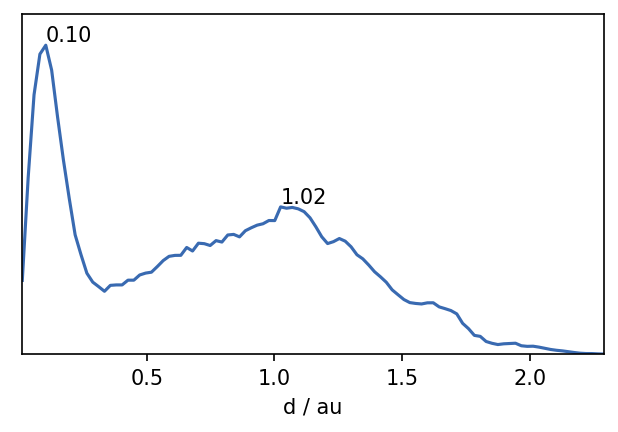

In [35]:
# Distance distribution for this cluster
robj1.calc_dist()
fig, ax, *_ = robj1.dist_hist(maxima=True, maxima_props={"order": 5})

Execution time for call of fit: 0 hours, 0 minutes, 0.0578 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
678       0.180     6         2         None      4         0.494     0.117     
--------------------------------------------------------------------------------
Execution time for call of fit: 0 hours, 0 minutes, 0.0143 seconds
--------------------------------------------------------------------------------
#points   R         N         M         max       #clusters %largest  %noise    
678       0.180     6         5         None      2         0.494     0.124     
--------------------------------------------------------------------------------


Text(0.5, 1.0, 'member cutoff 5')

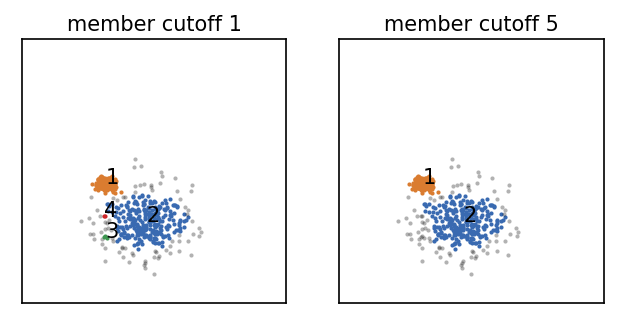

In [36]:
# Now cluster the child cluster
fig, Ax = plt.subplots(1, 2)
robj1.fit(0.18, 6)
_ = robj1.evaluate(ax=Ax[0], ax_props=ax_props)
Ax[0].set_title(f"member cutoff 1", fontsize=10, pad=4)

# When the result is satisfying, but also a few very small clusters are found,
# this can be surpressed
robj1.fit(0.18, 6, member_cutoff=5)
_ = robj1.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[1].set_title(f"member cutoff 5", fontsize=10, pad=4)

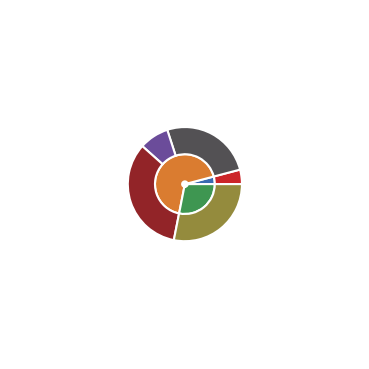

In [37]:
# The cluster hierarchy can be visualised as pie diagram (not fully functional)
robj.pie()

In [89]:
# Wrap up the hierarchical clustering and integrate the child clusters into
# the parent cluster
robj.reel()
robj.labels.sort_by_size()

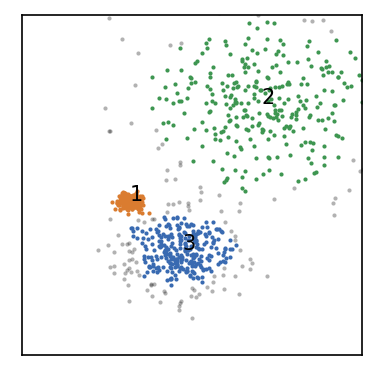

In [48]:
fig, ax = plt.subplots()
_ = robj.evaluate(ax=ax, ax_props=ax_props)

From neighbours prediction in 9.66 seconds

From neighbours prediction in 9.72 seconds

From neighbours prediction in 6.15 seconds



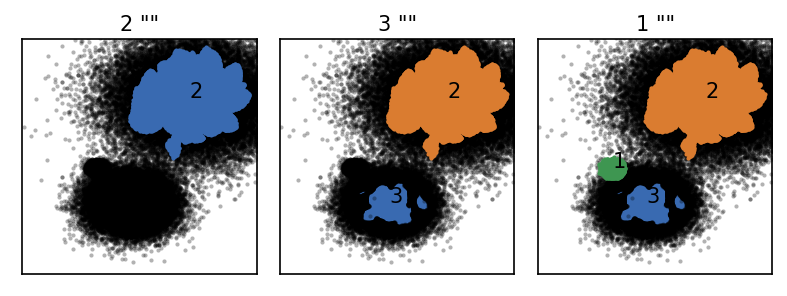

In [56]:
# In the end the cluster assignment for the (reduced) train set can be mapped
# onto another test set. The assignment prediction can (and should) be done
# for each cluster individually. 
cobj.calc_dist(robj)  # Distance map calculation

fig, Ax = plt.subplots(1, 3)

go = time.time()
robj.predict(cobj, 0.4, 3, clusters=[2], purge=True)
print(f"From neighbours prediction in {time.time()-go:.2f} seconds\n")
time.sleep(1)
_ = cobj.evaluate(ax=Ax[0], ax_props=ax_props)
Ax[0].set_title(f'2 ""', fontsize=10, pad=4)


go = time.time()
robj.predict(cobj, 0.2, 5, clusters=[3])
print(f"From neighbours prediction in {time.time()-go:.2f} seconds\n")
_ = cobj.evaluate(ax=Ax[1], ax_props=ax_props)
Ax[1].set_title(f'3 ""', fontsize=10, pad=4)

go = time.time()
robj.predict(cobj, 0.15, 10, clusters=[1])
print(f"From neighbours prediction in {time.time()-go:.2f} seconds\n")
_ = cobj.evaluate(ax=Ax[2], ax_props=ax_props)
Ax[2].set_title(f'1 ""', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

In [58]:
robj.labels.info

LabelInfo(origin='fitted', reference=None, params={'all': (0.6, 17)})

In [57]:
cobj.labels.info

LabelInfo(origin='predicted', reference=<core.cnn.CNN object at 0x7fd292e40eb0>, params={2: (0.4, 3), 3: (0.2, 5), 1: (0.15, 10)})

Predicting: 100%|██████████| 100k/100k [00:14<00:00, 6.95kPoints/s] 


On-the-fly prediction in 14.43 seconds



Mapping: 100%|██████████| 10.0/10.0 [00:00<00:00, 18.3Chunks/s]


Distance calculation in 0.58 seconds


Predicting: 100%|██████████| 74.3k/74.3k [00:04<00:00, 18.4kPoints/s]


Lookup (mmap) in 4.18 seconds

Tree built in 0.00 seconds


Predicting: 100%|██████████| 50.3k/50.3k [00:10<00:00, 4.66kPoints/s]


Tree prediction in 10.82 seconds



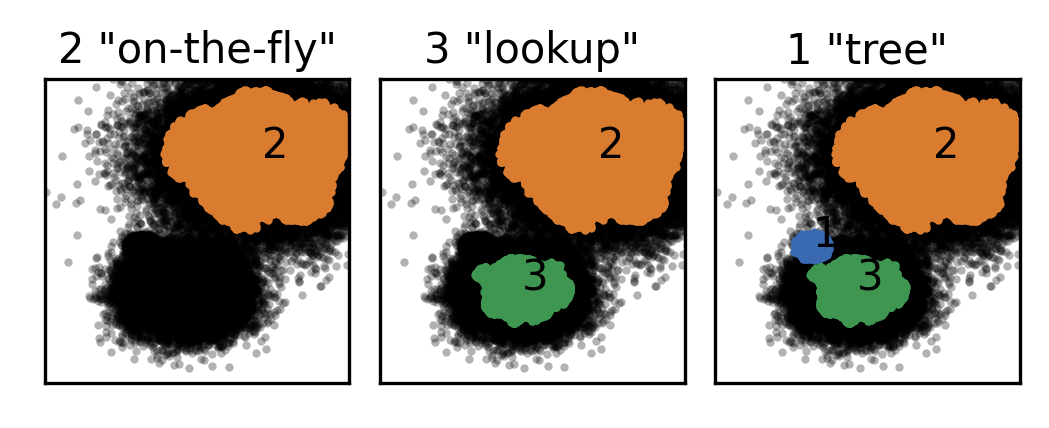

In [45]:
# In the end the cluster assignment for the (reduced) train set can be mapped
# onto another test set. The assignment prediction can (and should) be done
# for each cluster individually.
# For the prediction procedure the user can choose between
# "on-the-fly" distance calculation (memory efficient, but rather
# slow), distance "lookup" from precalculated distance matrices (fast, but
# memory hungry; consider calculating the matrices in memmap mode) and a
# "tree" search of nearest neighbours (balanced speed and memory wise). 
fig, Ax = plt.subplots(1, 3)

# on-the-fly
go = time.time()
cobj.predict(0.47, 15, clusters=[2], behaviour="on-the-fly", purge=True)
print(f"On-the-fly prediction in {time.time()-go:.2f} seconds\n")
time.sleep(1)
_ = cobj.evaluate(ax=Ax[0], ax_props=ax_props, mode="test")
Ax[0].set_title(f'2 "on-the-fly"', fontsize=10, pad=4)

# lookup
go = time.time()
# cobj.dist(mmap=True)
cobj.map(mmap=True)
print(f"Distance calculation in {time.time()-go:.2f} seconds")
time.sleep(1)

go = time.time()
cobj.predict(0.15, 5, clusters=[3], behaviour="lookup")
print(f"Lookup (mmap) in {time.time()-go:.2f} seconds\n")
_ = cobj.evaluate(ax=Ax[1], ax_props=ax_props, mode="test")
Ax[1].set_title(f'3 "lookup"', fontsize=10, pad=4)

# KDTree search
go = time.time()
cobj.kdtree()
print(f"Tree built in {time.time()-go:.2f} seconds")
time.sleep(1)

go = time.time()
cobj.predict(0.15, 10, clusters=[1], behaviour="tree")
print(f"Tree prediction in {time.time()-go:.2f} seconds\n")
_ = cobj.evaluate(ax=Ax[2], ax_props=ax_props, mode="test")
Ax[2].set_title(f'1 "tree"', fontsize=10, pad=4)

fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, wspace=0.1, hspace=0.3 
    )

# MD showcase - Langerin

In [47]:
cobj = cnn.CNN(test=[x[::20, :6] for x in np.load("../data/md_showcase_langerin.npy", allow_pickle=True)])
cobj.cut(points=(None, None, 10))

In [49]:
print(cobj)

cnn.CNN cluster object
--------------------------------------------------------------------------------
alias :                                  root
hierachy level :                         0

test data shape :                        Parts      - 118
                                         Points     - [558, 415, 2086, 9993, 1413, '...']
                                         Dimensions - 6

train data shape :                       Parts      - 118
                                         Points     - [56, 42, 209, 1000, 142, '...']
                                         Dimensions - 6

distance matrix calculated (train) :     False
distance matrix calculated (test) :      False
clustered :                              False
children :                               False
--------------------------------------------------------------------------------



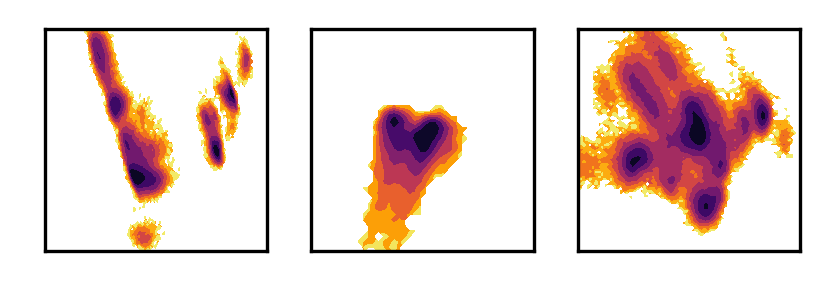

In [50]:
mode = "test"
fig, Ax = plt.subplots(
    1, 3,
    figsize=(mpl.rcParams['figure.figsize'][0],
             mpl.rcParams['figure.figsize'][1]*0.5)
    )

for dim in range(3):
    _ = cobj.evaluate(
        ax=Ax[dim], plot="contourf",
        mode=mode, ax_props=ax_props,
        dim=(dim*2, dim*2 + 1)
        )

<a name="space_a" />

## Space A

In [114]:
# Load the data
# 130 replica of holo-langerin;
# 100 ps time step;
# 5 dimensional TICA projection;
# 30 ns lag time, selected bb-dihedrals and H-bonds
proj = np.load('p30_5.npy', allow_pickle=True)
print(np.shape(proj), np.shape(proj[0]))

(130,) (4002, 5)


In [25]:
# optionally reduce dimensionality
# for i in range(len(proj)):
#     proj[i] = proj[i][:, :3]

In [115]:
# initialise clustering
langerin = cnn.CNN(test=proj)
langerin.cut(points=(None, None, 100))
print(langerin)

Configuration file found in /home/janjoswig
cnn.CNN cluster object
--------------------------------------------------------------------------------
alias :                                  root
hierachy level :                         0

test data shape :                        Parts      - 130
                                         Points     - [4002, 2501, 2201, 2201, 2201, '...']
                                         Dimensions - 5

train data shape :                       Parts      - 130
                                         Points     - [41, 26, 23, 23, 23, '...']
                                         Dimensions - 5

distance matrix calculated (train) :     False
distance matrix calculated (test) :      False
clustered :                              False
children :                               False
--------------------------------------------------------------------------------



<a name="clustering" />

### Clustering

Train distance matrix not calculated. Calculating distance matrix.


(<Figure size 975.192x602.669 with 1 Axes>,
 [Text(0.35896362584191055, 0.7247888035798966, '0.36'),
  Text(1.7948178889355477, 0.43464846777076316, '1.79'),
  Text(3.2306721520291855, 0.2663797558984762, '3.23'),
  Text(7.251064088691371, 0.050229576941857444, '7.25'),
  Text(11.271456025353556, 0.018509623274021017, '11.27')])

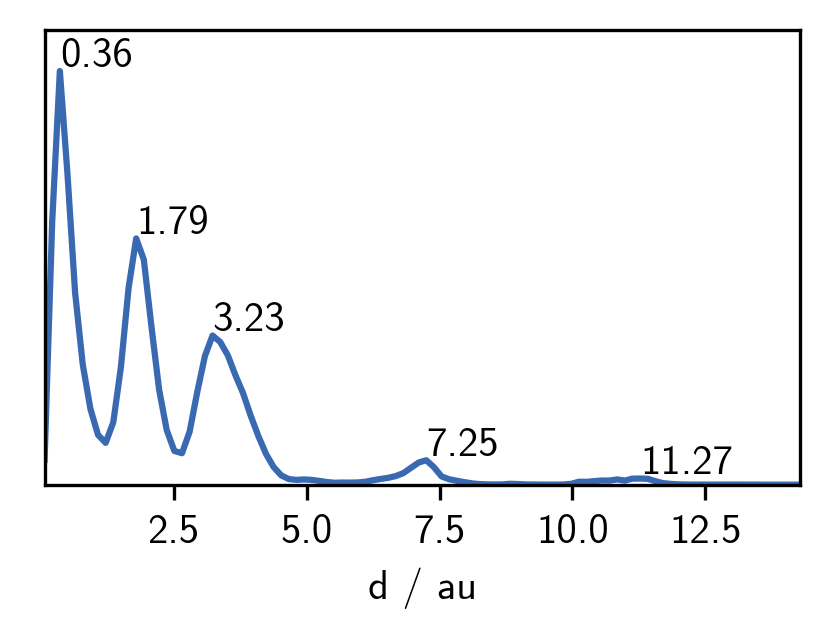

In [116]:
# Distance histogram
langerin.dist_hist(maxima=True, maxima_props={"order": 5})

In [118]:
# Axis property defaults for the following plots
ax_props2 = {
    "xlabel": None,
    "ylabel": None,
    "xticks": (),
    "yticks": (),
}

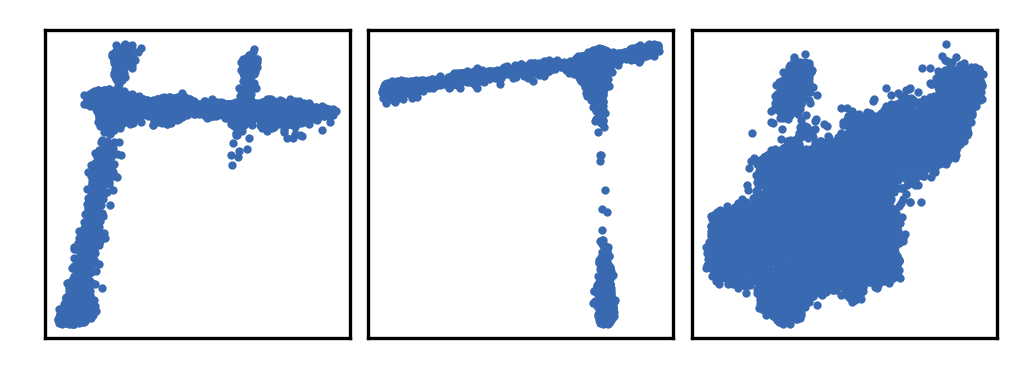

In [119]:
# Have a look at the original data ...
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2, mode="test", original=True)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2), mode="test", original=True)
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4), mode="test", original=True)
fig.tight_layout(pad=0.1)

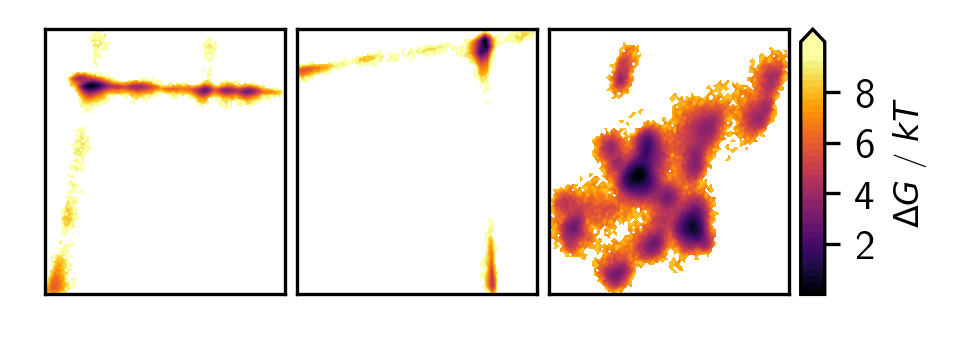

In [121]:
# Alternatively plot this as free energy landscape
obj = langerin
fig = plt.figure(figsize=(6.50128*0.5, 6.50128*0.2*0.618*1.1))
Ax = []
gspec = fig.add_gridspec(1, 22)
Ax.append(fig.add_subplot(gspec[0, :7]))
Ax.append(fig.add_subplot(gspec[0, 7:14]))
Ax.append(fig.add_subplot(gspec[0, 14:21]))
Ax.append(fig.add_subplot(gspec[0, -1]))
plotted = obj.evaluate(
    ax=Ax[0], ax_props=ax_props2,
    mode="test", original=True,
    plot='contourf', contour_props={"levels": 40, "vmin": 0, "vmax": 9.5, "extend": "max"}
    )[2]
obj.evaluate(
    ax=Ax[1], ax_props=ax_props2,
    dim=(1, 2),
    mode="test", original=True,
    plot='contourf', contour_props={"levels": 40, "vmin": 0, "vmax": 9.5}
    )
obj.evaluate(
    ax=Ax[2], ax_props=ax_props2,
    dim=(3, 4),
    mode="test", original=True,
    plot='contourf', contour_props={"levels": 40, "vmin": 0, "vmax": 9.5}
    )
# cbarax = fig.add_subplot(1, 20, 20)
cbar = fig.colorbar(mappable=plotted[0], cax=Ax[3], ticks=(2, 4, 6, 8))
cbar.set_label(r"$\Delta G$ / $kT$", fontsize=8)
fig.subplots_adjust(
    left=0, right=0.8, bottom=0, top=1, wspace=0.5, hspace=1 
    )

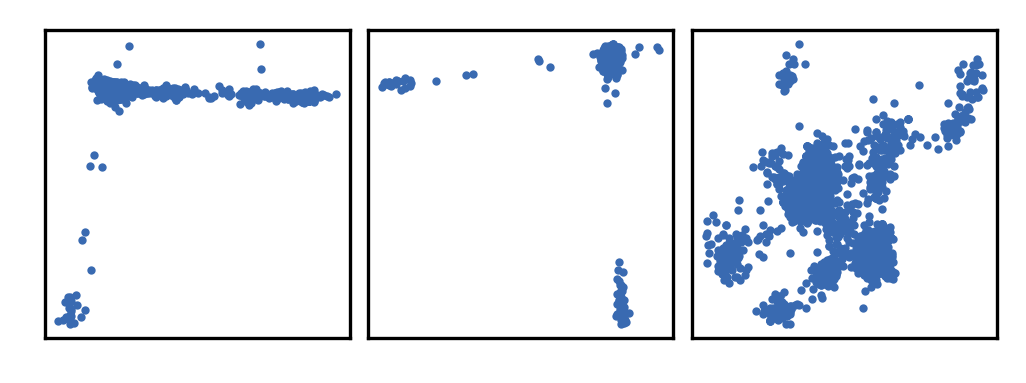

In [122]:
# ... and the reduced set
# Have a look at the original data
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2, original=True)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2), original=True)
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4), original=True)
fig.tight_layout(pad=0.1)


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    3141      4.0    5     1    None         3         0.97453       0.0   
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 2.0126 seconds
recording: ...


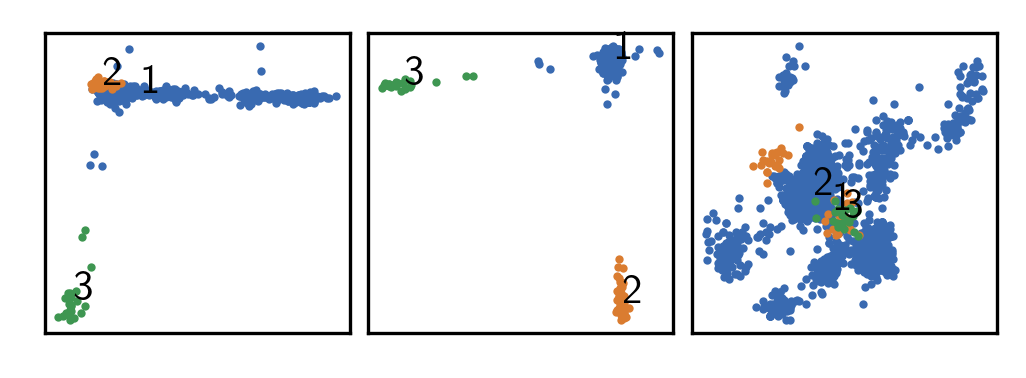

In [123]:
# Level 1
r, c = 4, 5
obj = langerin
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c_{r}_{c}.png")

In [124]:
# Isolate the result and prepare for level 2
langerin.isolate()
l1 = langerin.train_children[1]
l2 = langerin.train_children[2]
l3 = langerin.train_children[3]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
     24       1.0    0     1    None         2          0.875     0.041667 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.0056 seconds
recording: ...


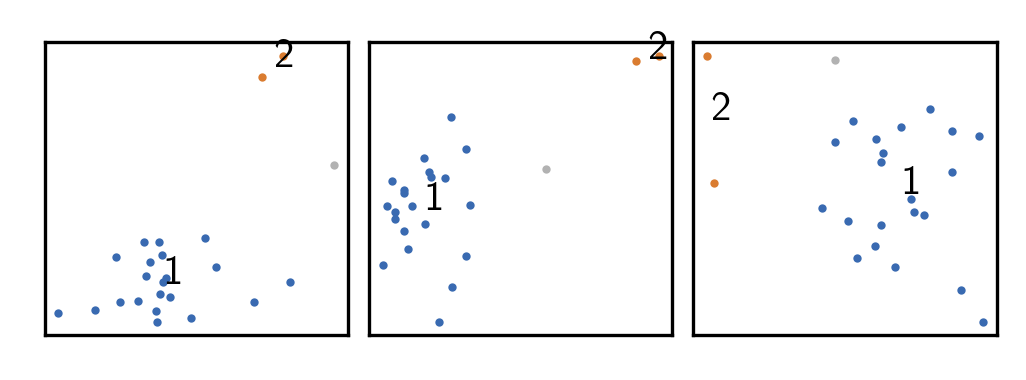

In [125]:
# Level 2, child 3
r, c = 1, 0
obj = l3
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c3_{r}_{c}.png")


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
     56       0.8    5     1    None         2        0.553571    0.035714 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.0058 seconds
recording: ...


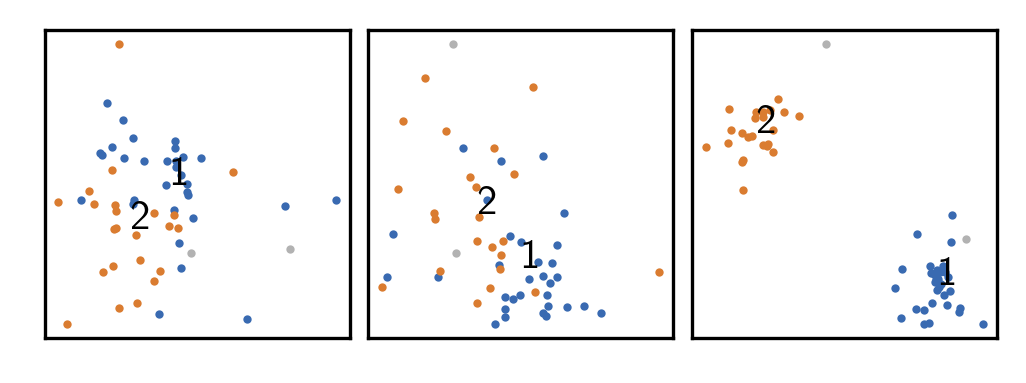

In [126]:
# Level 2, child 2
r, c = 0.8, 5
obj = l2
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c2_{r}_{c}.png")


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    3061      1.3    0     1    None         3        0.991833       0.0   
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 1.2624 seconds
recording: ...


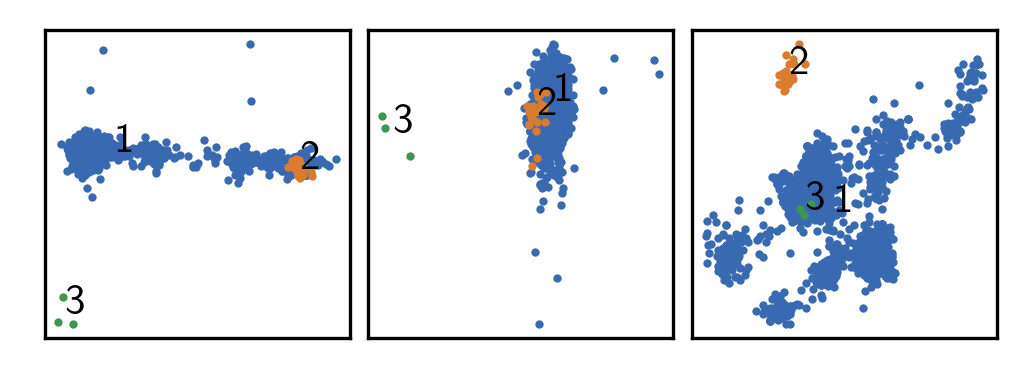

In [127]:
# Level 2, child 1
r, c = 1.3, 0
obj = l1
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_{r}_{c}.png")

In [128]:
# Isolate from l1 and prepare for level 3
l1.isolate()
l1_1 = l1.train_children[1]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    3036      0.9    0     0    None         6        0.972661       0.0   
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 1.1927 seconds
recording: ...


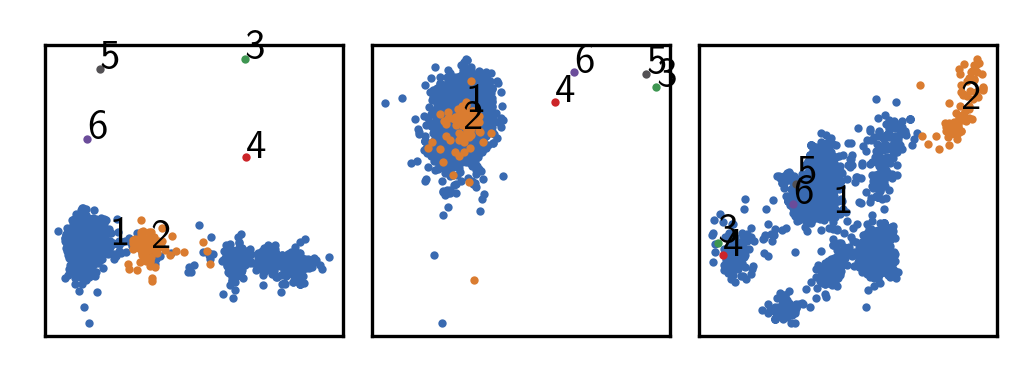

In [129]:
# Level 3, child 1
r, c = 0.9, 0
obj = l1_1
obj.fit(radius_cutoff=r, cnn_cutoff=c, member_cutoff=0)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_{r}_{c}.png")

In [130]:
# Isolate from l1_1 and prepare for level 4
l1_1.isolate()
l1_1_1 = l1_1.train_children[1]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    2953      0.6   10     1    None         4        0.850999    0.013207 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.8132 seconds
recording: ...


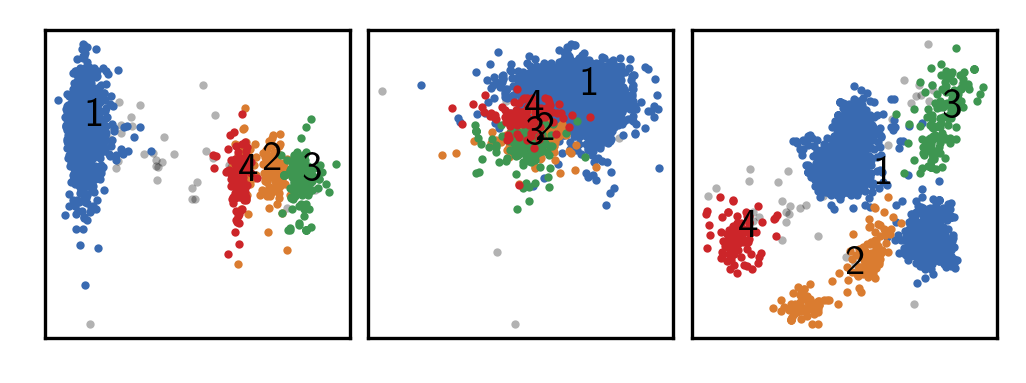

In [131]:
# Level 4, child 1
r, c = 0.6, 10
obj = l1_1_1
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_2_{r}_{c}.png")

In [132]:
# Isolate from l1_1_1 and prepare for level 5
l1_1_1.isolate()
l1_1_1_1 = l1_1_1.train_children[1]
l1_1_1_2 = l1_1_1.train_children[2]

Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig
Configuration file found in /home/janjoswig



-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
     158      0.4   15     1    None         2        0.525316    0.113924 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.0100 seconds
recording: ...


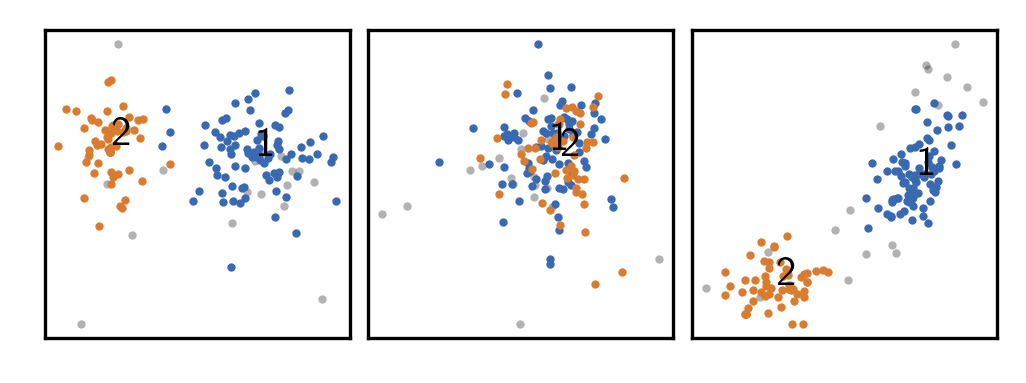

In [133]:
# Level 5, child 2
r, c = 0.4, 15
obj = l1_1_1_2
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_2_{r}_{c}.png")


-------------------------------------------------------------------------------
  #points     R     N     M     max     #clusters     %largest     %noise  
    2513      0.4   20     1    None         2        0.653402    0.024274 
-------------------------------------------------------------------------------
Execution time for call of fit():     0 hours, 0 minutes, 0.5373 seconds
recording: ...


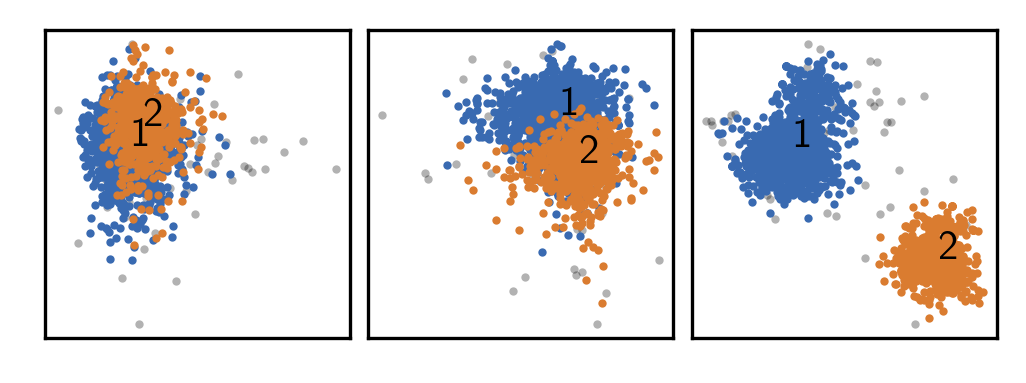

In [134]:
# Level 5, child 1
r, c = 0.4, 20
obj = l1_1_1_1
obj.fit(radius_cutoff=r, cnn_cutoff=c)
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_1_{r}_{c}.png")

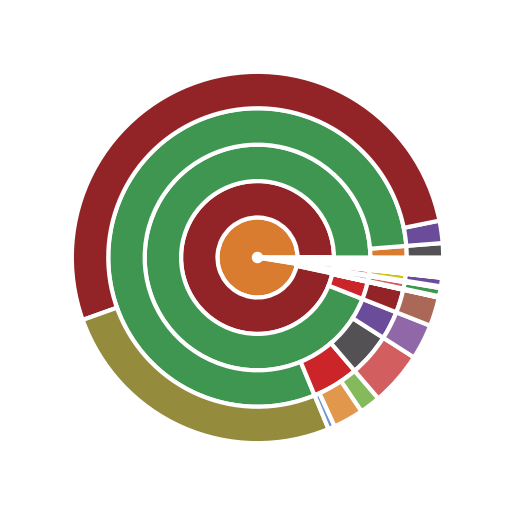

In [135]:
# Finished?
langerin.pie()

In [136]:
# Wrap up from child to parent
l1_1_1.reel()
l1_1.reel()
l1.reel()
langerin.reel()

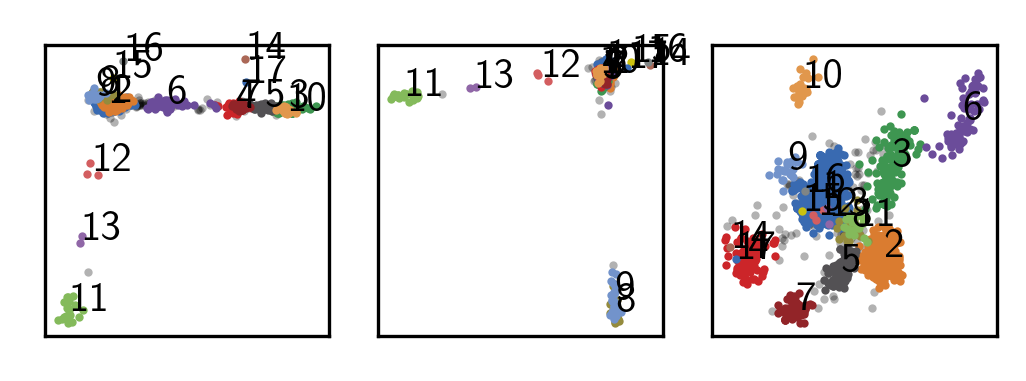

In [137]:
# Plot the total clustering result
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=ax_props2)
obj.evaluate(ax=Ax[1], ax_props=ax_props2, dim=(1, 2))
obj.evaluate(ax=Ax[2], ax_props=ax_props2, dim=(3, 4))
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_2_{r}_{c}.png")

In [138]:
# Cluster size overview
print(json.dumps({k: len(v) for k, v in langerin.train_clusterdict.items()}, indent=4))

{
    "0": 121,
    "1": 1642,
    "2": 810,
    "3": 147,
    "4": 96,
    "5": 83,
    "6": 79,
    "7": 57,
    "8": 31,
    "9": 23,
    "10": 22,
    "11": 21,
    "12": 3,
    "13": 2,
    "14": 1,
    "15": 1,
    "16": 1,
    "17": 1
}


In [405]:
# store train set assignments
# np.save("train_labels_30_5.npy", langerin.train_labels)

In [9]:
# load train set assignments
langerin.train_labels = np.load("train_labels_30_5.npy", allow_pickle=True)
# translate label information into clusterdict information
langerin.labels2dict()

In [10]:
# Prepare distance matrices for lookup
langerin.dist()
langerin.map()

In [ ]:
# Predict labels for the test set
# Going from small to large
langerin.predict(0.2, 0, clusters=[14, 15, 16, 17], behaviour="lookup")

In [ ]:
langerin.predict(0.5, 1, clusters=[12, 13], behaviour="lookup")

In [ ]:
langerin.predict(0.5, 5, clusters=[10, 11], behaviour="lookup")

In [ ]:
langerin.predict(0.4, 20, clusters=[1, 2], behaviour="lookup")

In [ ]:
langerin.predict(0.4, 10, clusters=[3, 4, 5, 6, 7, 8, 9], behaviour="lookup")

In [ ]:
# Plot the total clustering result
obj = langerin
fig, Ax = plt.subplots(1, 3, figsize=(6.50128*0.5, 6.50128*0.25*0.618*1.1))
obj.evaluate(ax=Ax[0], ax_props=axprops, mode="test")
obj.evaluate(ax=Ax[1], ax_props=axprops, dim=(1, 2), mode="test")
obj.evaluate(ax=Ax[2], ax_props=axprops, dim=(3, 4), mode="test")
fig.tight_layout(pad=0.1)
# # fig.savefig(f"c1_1_1_2_{r}_{c}.png")

<a name="cmsm" />

### Coreset MSM estimation

#### (MSM on train data *dt* = 10 ns)

In [18]:
# Create an MSM object
M = cmsm.CMSM(langerin.get_dtraj(mode='train'), unit="ns", step=10)

In [21]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 2, 3, 4]
for i in lags:
    M.cmsm(lag=i, minlenfactor=5)
    M.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 10 ns
---------------------------------------------------------

Trajectories [38]
are shorter then step threshold (lag*minlenfactor = 5)
and will not be used to compute the MSM.

Using 129 trajectories with 3126 steps over 17 coresets
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 20 ns
---------------------------------------------------------

Trajectories [38]
are shorter then step threshold (lag*minlenfactor = 10)
and will not be used to compute the MSM.

Using 129 trajectories with 3126 steps over 17 coresets
---------------------------------------------------------
****************************************************

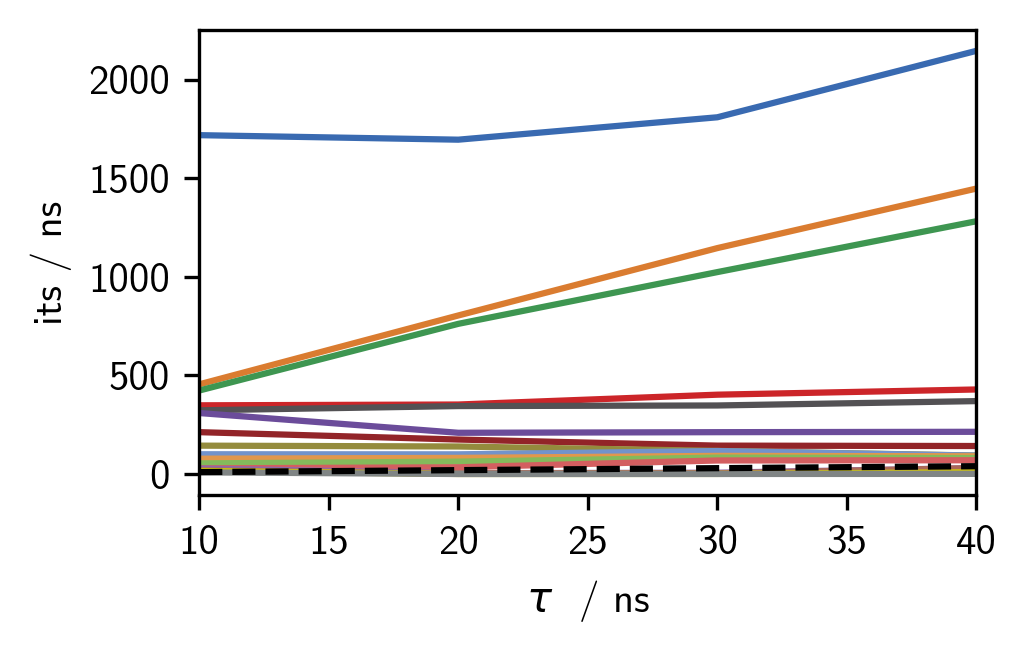

In [22]:
# Plot the time scales
fig, ax, *_ = M.plot_its()
fig.tight_layout(pad=0.1)

<a name="space_b" />

## Space B

In [139]:
# Load the data
# 130 replica of holo-langerin;
# 100 ps time step;
# 9 dimensional TICA projection;
# 9 ns lag time, selected bb-dihedrals and H-bonds
proj = np.load('p9_9.npy', allow_pickle=True)
print(np.shape(proj), np.shape(proj[0]))

(130,) (4002, 9)


In [140]:
# optionally reduce dimensionality
for i in range(len(proj)):
    proj[i] = proj[i][:, :3]

In [141]:
# initialise clustering
langerin_b = cnn.CNN(test=proj)
langerin_b.cut(points=(None, None, 100))
print(langerin_b)

Configuration file found in /home/janjoswig
cnn.CNN cluster object
--------------------------------------------------------------------------------
alias :                                  root
hierachy level :                         0

test data shape :                        Parts      - 130
                                         Points     - [4002, 2501, 2201, 2201, 2201, '...']
                                         Dimensions - 3

train data shape :                       Parts      - 130
                                         Points     - [41, 26, 23, 23, 23, '...']
                                         Dimensions - 3

distance matrix calculated (train) :     False
distance matrix calculated (test) :      False
clustered :                              False
children :                               False
--------------------------------------------------------------------------------



# [...]

<a name="clustering_b" />

### Clustering

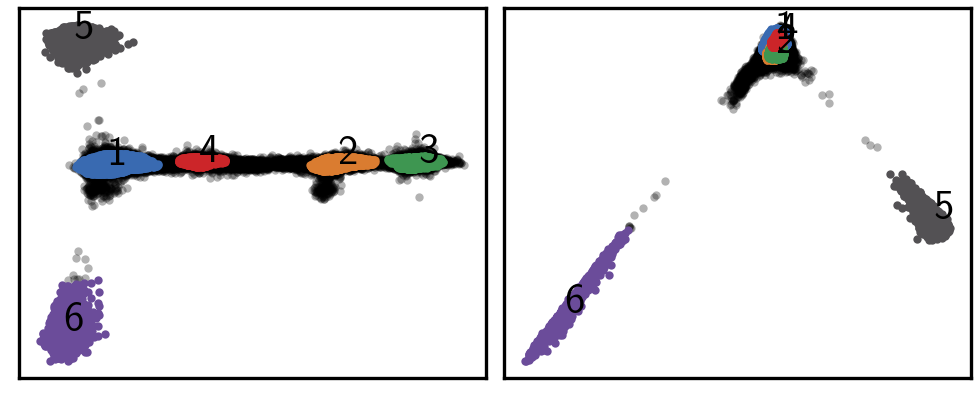

In [142]:
# You can also use this clustering and skip the prediction ...
Image("c_predicted_9_3.png")

In [143]:
# load train and test set assignments
langerin_b.train_labels = np.load("train_labels_9_3.npy", allow_pickle=True)
langerin_b.test_labels = np.load("test_labels_9_3.npy", allow_pickle=True)
# translate label information into clusterdict information
langerin_b.labels2dict()
langerin_b.labels2dict(mode="test")

<a name="cmsm_b" />

### Coreset MSM estimation

#### (MSM on test data *dt* = 0.1 ns)

In [144]:
# Create an MSM object
MB = cmsm.CMSM(langerin_b.get_dtraj(mode='test'), unit="ns", step=0.1)

In [145]:
# Estimate csMSM for different lag times (given in steps)
lags = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300]
for i in lags:
    MB.cmsm(lag=i, minlenfactor=5)
    MB.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 0.1 ns
---------------------------------------------------------

Using 130 trajectories with 301170 steps over 6 coresets
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 1.0 ns
---------------------------------------------------------

Using 130 trajectories with 301170 steps over 6 coresets
---------------------------------------------------------
*********************************************************


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 2.0 ns
---------------------------------------------------------

Traj

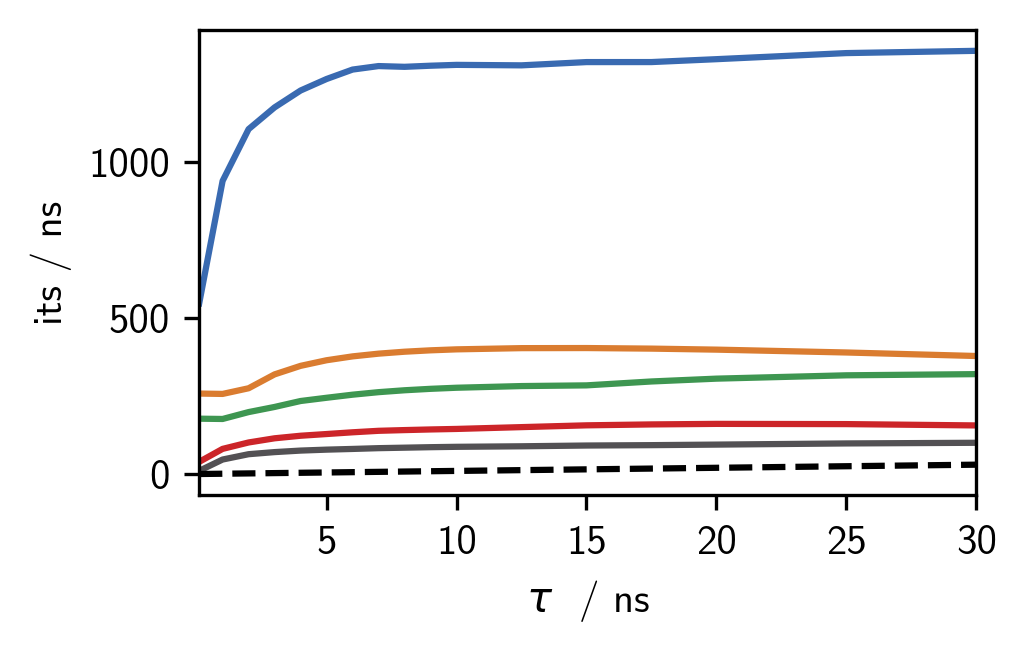

In [146]:
# Plot the implied time scales
fig, ax, *_ = MB.plot_its()
fig.tight_layout(pad=0.1)

In [147]:
# A Model at lag time 10 ns might be a good choice
MB.cmsm(lag=100)
MB.get_its()


*********************************************************
---------------------------------------------------------
Computing coreset MSM at lagtime 10.0 ns
---------------------------------------------------------

Trajectories [38]
are shorter then step threshold (lag*minlenfactor = 1000)
and will not be used to compute the MSM.

Using 129 trajectories with 301089 steps over 6 coresets
---------------------------------------------------------
*********************************************************



In [148]:
# Transition matrix
MB.T

array([[ 9.96803579e-01,  2.88007674e-04, -2.90934852e-07,
         1.85104164e-03,  7.84927156e-04,  2.72735582e-04],
       [ 2.67709646e-03,  9.68344445e-01,  2.16534956e-02,
         7.32579034e-03, -4.98370471e-08, -7.77422813e-07],
       [-7.50856852e-05,  3.43212694e-02,  9.52231599e-01,
         1.35221937e-02,  1.39780127e-09,  2.18047147e-08],
       [ 5.29790349e-02,  2.23999339e-02,  2.60014695e-02,
         8.98635933e-01, -9.86262053e-07, -1.53849930e-05],
       [ 3.47243911e-02,  1.40713811e-08, -1.42143962e-11,
        -6.79784120e-06,  9.65292477e-01, -1.00838853e-05],
       [ 2.44734782e-02,  9.91739893e-09, -1.00181948e-11,
        -4.79106511e-06, -4.55600275e-07,  9.75531759e-01]])

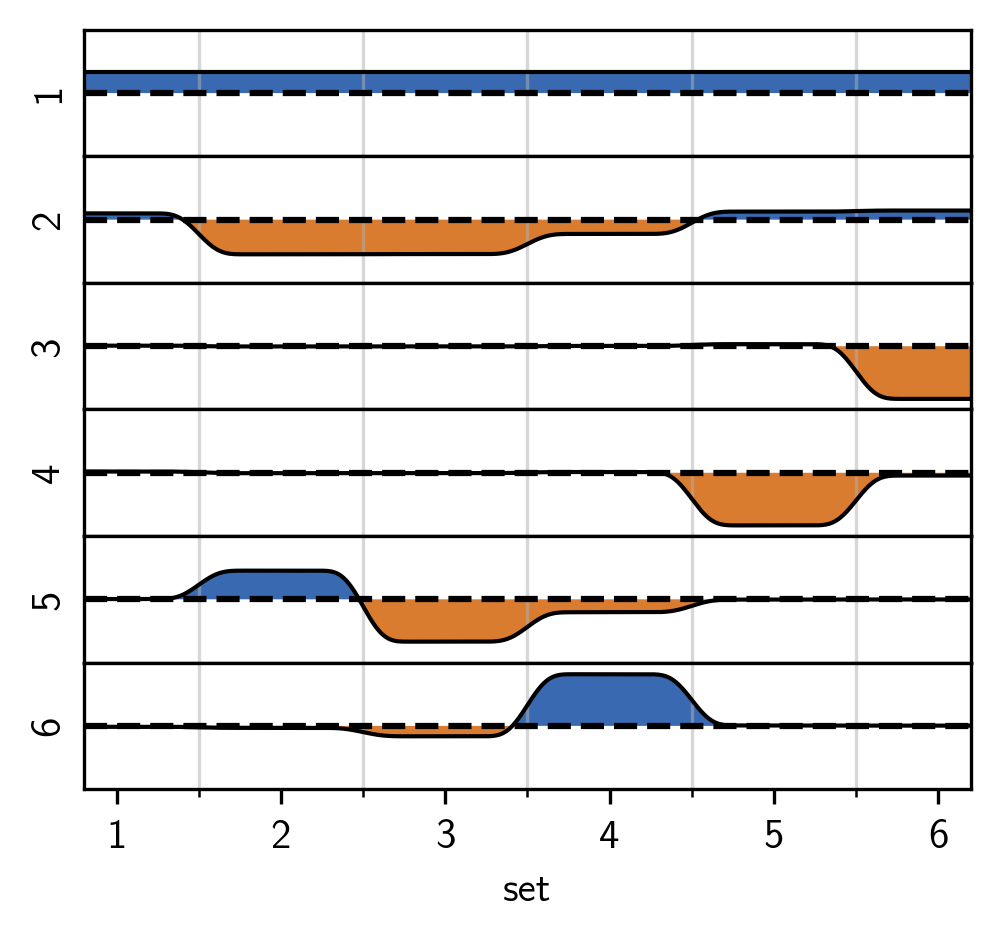

In [149]:
# You can plot the eigenvectors of the transition matrix (right)
mpl.rcParams['figure.figsize'] = 6.50128*0.5, 6.50128*0.5*0.618*1*0.25
fig, Ax = MB.plot_eigenvectors()
fig.subplots_adjust(
    left=0.08,
    bottom=0.15,
    right=0.99,
    top=0.99,
    wspace=None,
    hspace=0
    )

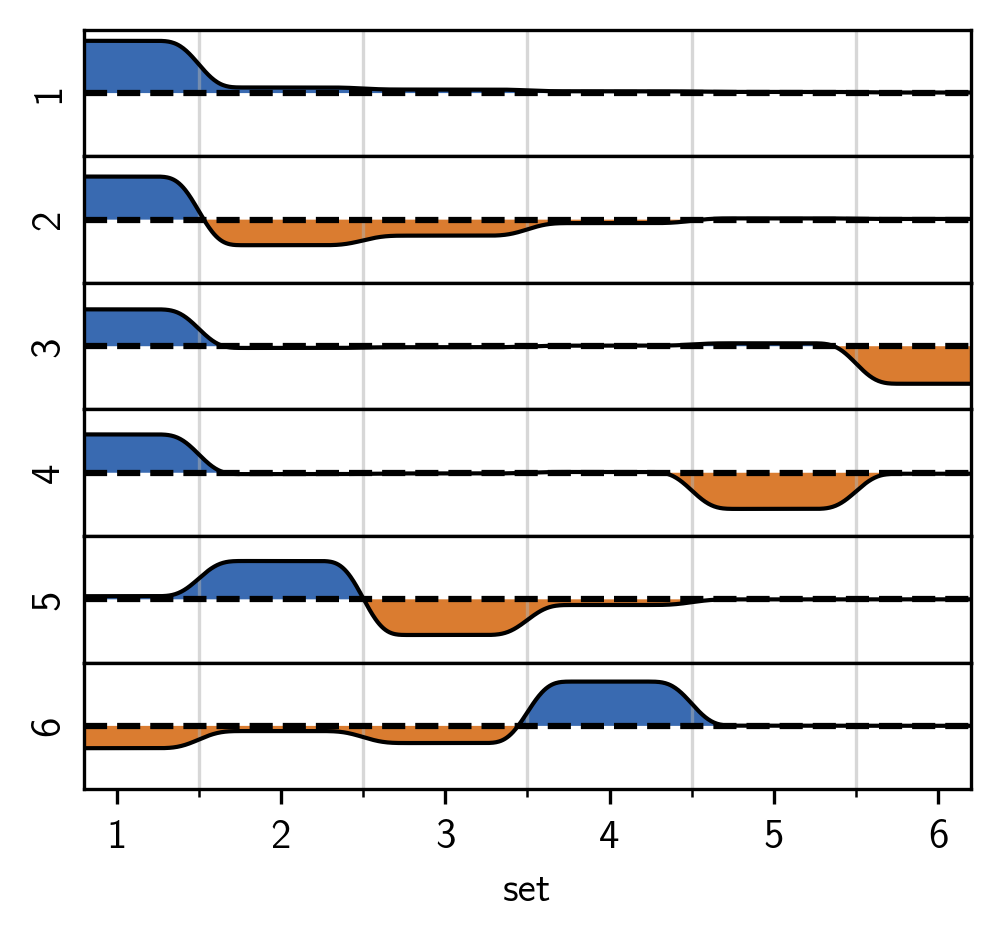

In [150]:
# You can plot the eigenvectors of the transition matrix (left)
mpl.rcParams['figure.figsize'] = 6.50128*0.5, 6.50128*0.5*0.618*1*0.25
fig, Ax = MB.plot_eigenvectors(which="left", invert=True)
fig.subplots_adjust(
    left=0.08,
    bottom=0.15,
    right=0.99,
    top=0.99,
    wspace=None,
    hspace=0
    )

<a name="benchmark" />

# Benchmark framework

In [ ]:
# Coming soon